In [67]:
import pickle
import numpy as np

with open('datapoints.pkl', 'rb') as f:
    data = pickle.load(f)

cars = [np.array(car) for car in zip(*data)]

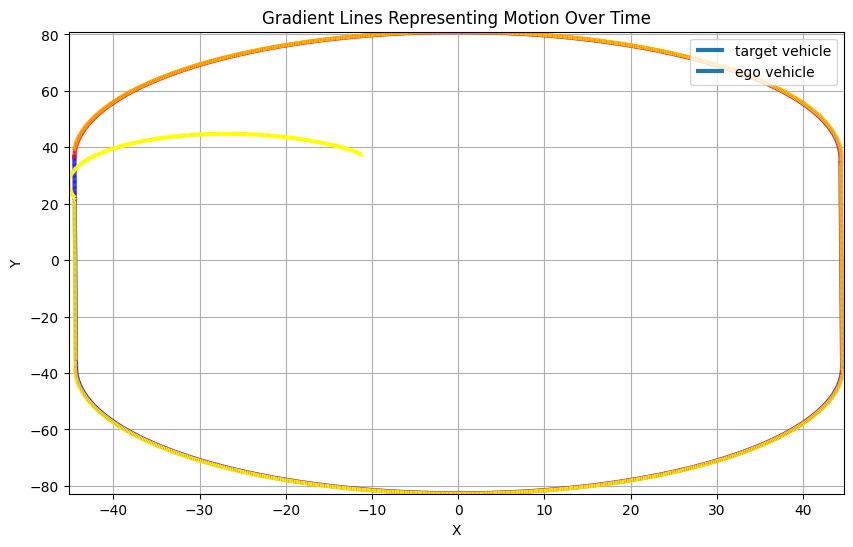

In [68]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

def plot_gradient_lines(xs, ys, colors, label=None):
    # Prepare points for line collection
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a continuous linear colormap
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)

    # Setting up the LineCollection
    lc = LineCollection(segments, cmap=cmap, linewidth=3)
    # Set the values used for colormapping
    lc.set_array(np.linspace(0, 1, len(xs)))
    lc.set_label(label)

    # Adding the collection to the plot
    plt.gca().add_collection(lc)

xs1 = cars[0][:, 0]
ys1 = cars[0][:, 1]

xs2 = cars[1][:, 0]
ys2 = cars[1][:, 1]

plt.figure(figsize=(10, 6))
# fig, ax = plt.subplots(2, 1, figsize=(10, 14))

# Plot each line with gradients
plot_gradient_lines(xs1, ys1, ["blue", "red"], label='target vehicle')
plot_gradient_lines(xs2, ys2, ["yellow", "orange"], label='ego vehicle')
plt.xlim(min(xs1.min(), xs2.min()), max(xs1.max(), xs2.max()))
plt.ylim(min(ys1.min(), ys2.min()), max(ys1.max(), ys2.max()))

plt.legend()
plt.title('Gradient Lines Representing Motion Over Time')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [60]:
print(cars[0].shape)

(2293, 4)


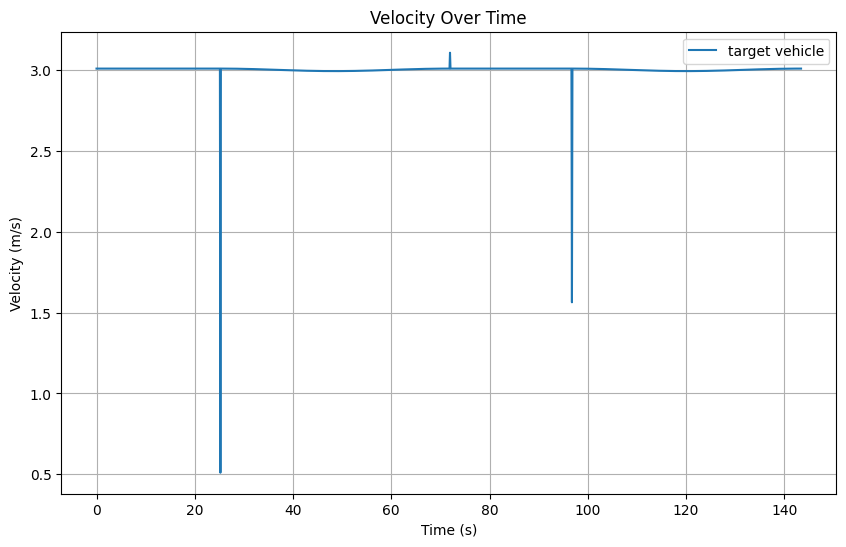

In [69]:
# plot all car velocities over time
time = np.linspace(0, 0.1*len(xs1), len(xs1))
plt.figure(figsize=(10, 6))

car0_v = cars[0][:,3]
# car1_v = cars[1][:,3]

plt.plot(time, car0_v, label='target vehicle')
# plt.plot(time, car1_v, label='ego vehicle')
plt.legend()
plt.title('Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

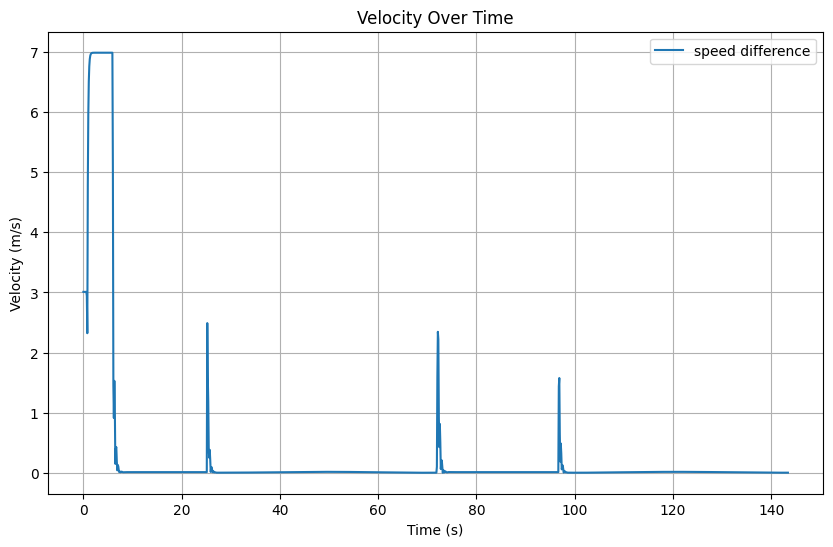

In [70]:
# plot the difference between max and min velocity over time
time = np.linspace(0, 0.1*len(xs1), len(xs1))
plt.figure(figsize=(10, 6))

car0_v = np.expand_dims(cars[0][:,3], 1)
car1_v = np.expand_dims(cars[1][:,3], 1)

concat_speeds = np.concatenate((car0_v, car1_v), axis=1)
max_speeds = np.max(concat_speeds, axis=1)
min_speeds = np.min(concat_speeds, axis=1)
speed_diff = max_speeds - min_speeds

plt.plot(time, speed_diff, label='speed difference')
plt.legend()
plt.title('Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

(1434,)
95th percentile error: 4.986329968202399


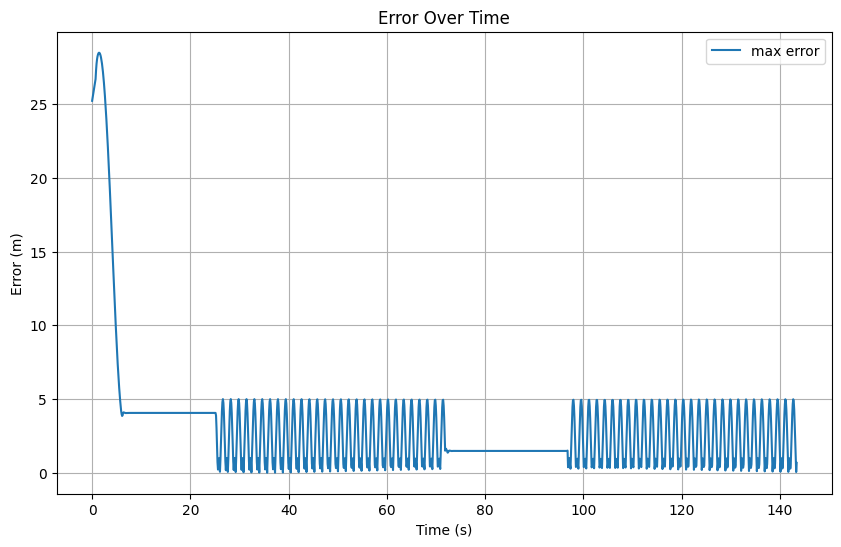

In [77]:
errors = np.array([])
max_errors = np.zeros((cars[0].shape[0], 1))

CAR_LENGTH = 0.779
FOLLOW_DISTANCE = 2.0

def distance_to_line(x0, y0, dx, dy, x, y):
    lambda_val = ((x - x0) * dx + (y - y0) * dy) / (dx**2 + dy**2)
    closest_point = np.array([x0 + lambda_val * dx, y0 + lambda_val * dy])
    distance = np.linalg.norm(closest_point - np.array([x, y]))
    return distance, closest_point

for i, car in enumerate(cars):
    if i == 0:
        continue
    
    current_x = cars[i][:, 0]
    current_y = cars[i][:, 1]

    for j in range(0, i):
        position = i - j
        goal_follow_distance = FOLLOW_DISTANCE*position + CAR_LENGTH*(position - 1)
        
        # x_goal = cars[j][:, 0] - goal_follow_distance*np.sin(cars[j][:, 2])
        # y_goal = cars[j][:, 1] - goal_follow_distance*np.cos(cars[j][:, 2])

        # error = np.sqrt((current_x - x_goal)**2 + (current_y - y_goal)**2)

        # Reference car position and heading
        ref_x = cars[j][:, 0]
        ref_y = cars[j][:, 1]
        ref_heading = cars[j][:, 2]

        # Project the current car's position onto the line defined by the reference car's position and heading
        dx = current_x - ref_x
        dy = current_y - ref_y
        
        # Compute the projection of the vector difference onto the direction of the reference car
        projected_length = dx * np.cos(ref_heading) + dy * np.sin(ref_heading)
        
        # Calculate the error as the absolute difference between the projected length and the goal follow distance
        error = np.abs(projected_length - goal_follow_distance)

        errors = np.append(errors, error)

        error = np.expand_dims(error, 1)
        max_errors = np.concatenate((max_errors, error), axis=1)
        max_errors = np.max(max_errors, axis=1)

print(errors.shape)

print(f"95th percentile error: {np.percentile(errors, 95)}")

time = np.linspace(0, 0.1*len(xs1), len(xs1))
plt.figure(figsize=(10, 6))

plt.plot(time, max_errors, label='max error')
plt.legend()
plt.title('Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.grid(True)
plt.show()
